In [22]:
import pandas as pd
import geopandas as gpd
from utilities.add_point_location import * #some functions were updated, not identical to GVV utils
import matplotlib.pyplot as plt

In [23]:
# read in ak places csv from GVV repo
gvv_df = pd.read_csv('https://raw.githubusercontent.com/ua-snap/geospatial-vector-veracity/main/vector_data/point/alaska_point_locations.csv')
gvv_df

,id,name,alt_name,region,country,latitude,longitude,km_distance_to_ocean
0,AK1,Afognak,Agw’aneq,Alaska,US,58.0078,-152.7680,0.2
1,AK2,Akhiok,Kasukuak,Alaska,US,56.9455,-154.1700,0.1
2,AK3,Akiachak,Akiacuar,Alaska,US,60.9094,-161.4310,89.7
3,AK4,Akiak,Akiaq,Alaska,US,60.9122,-161.2140,97.4
4,AK5,Akutan,Achan-ingiiga,Alaska,US,54.1385,-165.7780,0.6
...,...,...,...,...,...,...,...,...
464,AK432,Womens Bay,NaN,Alaska,US,57.7099,-152.5860,1.1
465,AK433,Woody Island,NaN,Alaska,US,57.7800,-152.3550,0.4
466,AK434,Wrangell,Shtax’héen,Alaska,US,56.4708,-132.3770,0.6
467,AK435,Yakutat,Yaakwdáat,Alaska,US,59.5469,-139.7270,0.7


In [24]:

# read in the csv of places to add
df = pd.read_csv('tbl/new_NCRPlaces_Census.csv')

# remove Adak and Eareckson Station from this list, since their coordinates do not return any data in NCR
droplist = ["Adak", "Eareckson Station"]
df = df[~df['name'].isin(droplist)]

# round coords to 4 decimal points as per specs in GVV repo
df["latitude"] = round(df["latitude"], 4)
df["longitude"] = round(df["longitude"], 4)

# finally, rename the "name" column so pandas doesnt get confused
df.rename(columns={"name": "community_name"}, inplace=True)

df

,id,community_name,alt_name,region,country,latitude,longitude,type,GEOIDFQ,PLACENAME,AREATYPE,COMMENT
0,NaN,Susitna,NaN,Alaska,US,61.5786,-150.6091,community,1600000US0274340,Susitna CDP,Census designated place,NaN
2,NaN,Alcan Border,NaN,Alaska,US,62.6856,-141.1253,community,1600000US0201390,Alcan Border CDP,Census designated place,NaN
3,NaN,Aleneva,NaN,Alaska,US,58.0046,-152.8825,community,1600000US0201560,Aleneva CDP,Census designated place,NaN
4,NaN,Badger,NaN,Alaska,US,64.8058,-147.4039,community,1600000US0205000,Badger CDP,Census designated place,NaN
5,NaN,Bear Creek,NaN,Alaska,US,60.1839,-149.3886,community,1600000US0205585,Bear Creek CDP,Census designated place,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
74,NaN,Tolsona,NaN,Alaska,US,62.0990,-146.0444,community,1600000US0278297,Tolsona CDP,Census designated place,NaN
75,NaN,Trapper Creek,NaN,Alaska,US,62.3114,-150.2458,community,1600000US0278680,Trapper Creek CDP,Census designated place,NaN
76,NaN,Whitestone,NaN,Alaska,US,64.1536,-145.8863,community,1600000US0284120,Whitestone CDP,Census designated place,NaN
77,NaN,Whitestone Logging Camp,NaN,Alaska,US,58.0831,-135.4367,community,1600000US0284200,Whitestone Logging Camp CDP,Census designated place,NaN


In [25]:
# add each place to the gvv dataframe using the gvv utility functions
# these functions will also attempt to round the lat/lon values to 4 decimal places

for index_, row in df.iterrows():

    last_id = get_last_id_number_in_df(gvv_df)
    new_id = create_new_id("AK", last_id)
    record = create_new_record(
            new_id,
            row.community_name,
            row.region,
            row.country,
            row.latitude,
            row.longitude,
            row.alt_name,
            )
    gvv_df = insert_new_record(gvv_df, record)
    gvv_df = sort_alphabetically(gvv_df)

In [26]:
# load global coastlines
coastline = gpd.read_file('shp/ne_10m_coastline.shp')

# convert the new gvv data to a geodataframe and plot
gdf = gpd.GeoDataFrame(gvv_df, geometry=gpd.points_from_xy(gvv_df['longitude'], gvv_df['latitude'], crs=4326))

(50.0, 75.0)

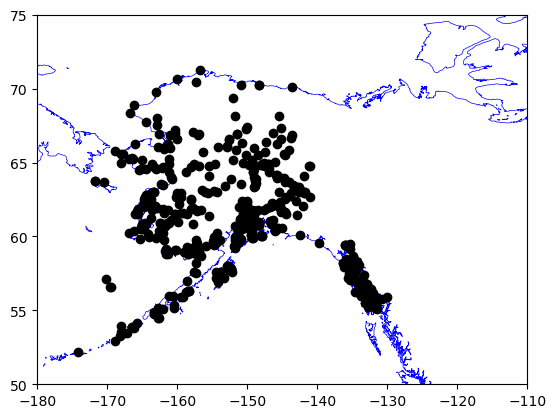

In [27]:
fig, ax = plt.subplots()

coastline.plot(ax=ax, color="blue", linewidth=.5, zorder=0)
gdf.plot(ax=ax, color="black", zorder=1)
ax.set_xlim(-180,-110)
ax.set_ylim(50, 75)

In [28]:
# convert to a projected coordinate system to calculate distance
coastline_3338 = coastline.to_crs(3338)
gdf_3338 = gdf.to_crs(3338)

In [29]:
# get distance of each point to any parts of the multiline geometry object
# divide by 1000 to get km, and round to 1 decimal place, and save the results to the gvv dataframe
coastline_geom = coastline_3338.unary_union
gvv_df['km_distance_to_ocean'] = gdf_3338['km_distance_to_ocean'] = round(gdf_3338.distance(coastline_geom)/1000, 1)

In [30]:
gvv_df

,id,name,alt_name,region,country,latitude,longitude,km_distance_to_ocean
0,AK1,Afognak,Agw’aneq,Alaska,US,58.0078,-152.7680,0.3
1,AK2,Akhiok,Kasukuak,Alaska,US,56.9455,-154.1700,0.7
2,AK3,Akiachak,Akiacuar,Alaska,US,60.9094,-161.4310,33.5
3,AK4,Akiak,Akiaq,Alaska,US,60.9122,-161.2140,43.0
4,AK5,Akutan,Achan-ingiiga,Alaska,US,54.1385,-165.7780,0.5
...,...,...,...,...,...,...,...,...
464,AK432,Womens Bay,NaN,Alaska,US,57.7099,-152.5860,2.2
465,AK433,Woody Island,NaN,Alaska,US,57.7800,-152.3550,1.9
466,AK434,Wrangell,Shtax’héen,Alaska,US,56.4708,-132.3770,0.1
467,AK435,Yakutat,Yaakwdáat,Alaska,US,59.5469,-139.7270,0.7


In [31]:
# save for upload to GVV
gvv_df.to_csv('/Users/joshpaul/epa-justice/repo/epa-justice/tbl/alaska_point_locations.csv', index=False)